# Discrete State with Markov Transitions

In [1]:
from copy import copy, deepcopy
from time import process_time

import numpy as np
import matplotlib.pyplot as plt

from HARK.ConsumptionSaving.ConsMarkovModel import (
    MarkovConsumerType,
    init_indshk_markov,
)
from HARK.distributions import DiscreteDistributionLabeled
from HARK.utilities import plot_funcs

mystr = lambda number: f"{number:.4f}"
do_simulation = True

This module defines consumption-saving models in which an agent has CRRA utility over consumption, geometrically discounts future utility flows and expects to experience transitory and permanent shocks to his/her income. Moreover, in any given period s/he is in exactly one of several discrete states. This state evolves from period to period according to a Markov process.

In this model, an agent is very similar to the one in the "idiosyncratic shocks" model of `ConsIndShockModel`, except that here, an agent's income distribution ($F_{\psi t},F_{\theta t}$), permanent income growth rate $\Gamma_{t+1}$ and interest factor $R$ are all functions of the Markov state and might vary across states.

The agent's problem can be written in Bellman form as:

\begin{eqnarray*}
v_t(m_t,s_t) &=& \max_{c_t} u(c_t) + \beta (1-\mathsf{D}_{t+1}) \mathbb{E} [v_{t+1}(m_{t+1}, s_{t+1}) ], \\
a_t &=& m_t - c_t, \\
a_t &\geq& \underline{a}, \\
m_{t+1} &=& \frac{R(s_{t+1})}{\Gamma(s_{t+1})\psi_{t+1}} a_t + \theta_{t+1}, \\
\theta_{t} \sim F_{\theta t}(s_t), &\qquad& \psi_{t} \sim F_{\psi t}(s_t), \mathbb{E} [F_{\psi t}(s_t)] = 1, \\
Prob[s_{t+1}=j| s_t=i] &=& \triangle_{ij}, \\
u(c) &=& \frac{c^{1-\rho}}{1-\rho}
\end{eqnarray*}

The Markov matrix $\triangle$ is giving transition probabilities from current state $i$ to future state $j$.

The one period problem for this model is solved by the function `solveConsMarkov`. The class `MarkovConsumerType` extends `IndShockConsumerType` to represents agents in this model.

To solve an instance of this class, the same attributes as for `IndShockConsumerType` are required, except for one as described below:

### Additional model input to solve an instance of `MarkovConsumerType`

| Param | Description | Code | Value | Constructed |
| :---: | --- | --- | --- | :---: |
| $\triangle$ |Discrete state transition probability matrix  | `MrkvArray` |  |$\surd$ |

The attribute `MrkvArray` is a `numpy.array` of size ($N_s$, $N_s$) corresponding to the number of discrete states.

Note that `MrkvArray` is am element of `time_inv`, so that the same transition probabilities are used for each period. However, it can be moved to `time_vary` and specified as a list of `array`s instead.

The attributes `Rfree`, `PermGroFac` and `IncomeDstn` should be specified as arrays or lists with $N_s$ elements for each period.

### Solve MarkovConsumerType

When the `solve()` method of a `MarkovConsumerType` is invoked, the `solution` attribute is populated with a list of `ConsumerSolution` objects, which each have the same attributes as the "idiosyncratic shocks" model. However, each attribute is now a list (or array) whose elements are *state-conditional* values of that object.

For example, in a model with 4 discrete states, each the `cFunc` attribute of each element of `solution` is a length-4 list whose elements are state-conditional consumption functions. That is, `cFunc[2]` is the consumption function when $s_t = 2$.

`ConsMarkovModel` is compatible with cubic spline interpolation for the consumption functions, so`CubicBool = True` will not generate an exception. The problem is solved using the [method of endogenous gridpoints](https://www.econ2.jhu.edu/people/ccarroll/EndogenousGridpoints.pdf), which is moderately more complicated than in the basic `ConsIndShockModel`.

Several variant examples of the model will be illustrated below:

1. Model with serially correlated unemployment
2. Model with period of "unemployment immunity"
3. Model with serially correlated permanent income growth
4. Model with serially correlated interest factor

### 1. Serial Unemployment

Let's create a consumer similar to the one in "idiosyncratic shock" model but who faces serially correlated unemployment during boom or bust cycles of the economy.

In [2]:
# Define the Markov transition matrix for serially correlated unemployment
unemp_length = 5  # Averange length of unemployment spell
urate_good = 0.05  # Unemployment rate when economy is in good state
urate_bad = 0.12  # Unemployment rate when economy is in bad state
bust_prob = 0.01  # Probability of economy switching from good to bad
recession_length = 20  # Averange length of bad state
p_reemploy = 1.0 / unemp_length
p_unemploy_good = p_reemploy * urate_good / (1 - urate_good)
p_unemploy_bad = p_reemploy * urate_bad / (1 - urate_bad)
boom_prob = 1.0 / recession_length
MrkvArray = np.array(
    [
        [
            (1 - p_unemploy_good) * (1 - bust_prob),
            p_unemploy_good * (1 - bust_prob),
            (1 - p_unemploy_good) * bust_prob,
            p_unemploy_good * bust_prob,
        ],
        [
            p_reemploy * (1 - bust_prob),
            (1 - p_reemploy) * (1 - bust_prob),
            p_reemploy * bust_prob,
            (1 - p_reemploy) * bust_prob,
        ],
        [
            (1 - p_unemploy_bad) * boom_prob,
            p_unemploy_bad * boom_prob,
            (1 - p_unemploy_bad) * (1 - boom_prob),
            p_unemploy_bad * (1 - boom_prob),
        ],
        [
            p_reemploy * boom_prob,
            (1 - p_reemploy) * boom_prob,
            p_reemploy * (1 - boom_prob),
            (1 - p_reemploy) * (1 - boom_prob),
        ],
    ],
)

In [3]:
# Make a consumer with serially correlated unemployment, subject to boom and bust cycles
init_serial_unemployment = copy(init_indshk_markov)
init_serial_unemployment["MrkvArray"] = [MrkvArray]
init_serial_unemployment["UnempPrb"] = np.zeros(2)
# Income process is overwritten below to make income distribution when employed
init_serial_unemployment["global_markov"] = False
init_serial_unemployment["Rfree"] = np.array([1.03, 1.03, 1.03, 1.03])
init_serial_unemployment["LivPrb"] = [np.array([0.98, 0.98, 0.98, 0.98])]
init_serial_unemployment["PermGroFac"] = [np.array([1.01, 1.01, 1.01, 1.01])]
SerialUnemploymentExample = MarkovConsumerType(**init_serial_unemployment)
SerialUnemploymentExample.cycles = 0
SerialUnemploymentExample.vFuncBool = False  # for easy toggling here

In [4]:
# Replace the default (lognormal) income distribution with a custom one
employed_income_dist = DiscreteDistributionLabeled(
    pmv=np.ones(1),
    atoms=np.array([[1.0], [1.0]]),
    var_names=["PermShk", "TranShk"],
)  # Definitely get income
unemployed_income_dist = DiscreteDistributionLabeled(
    pmv=np.ones(1),
    atoms=np.array([[1.0], [0.0]]),
    var_names=["PermShk", "TranShk"],
)  # Definitely don't
SerialUnemploymentExample.IncShkDstn = [
    [
        employed_income_dist,
        unemployed_income_dist,
        employed_income_dist,
        unemployed_income_dist,
    ],
]
SerialUnemploymentExample.assign_parameters(MrkvArray=[MrkvArray])

In [5]:
# Interest factor, permanent growth rates, and survival probabilities are constant arrays
SerialUnemploymentExample.assign_parameters(Rfree=[np.array(1.03 * np.ones(4))])
SerialUnemploymentExample.PermGroFac = [1.0 * np.ones(4)]
SerialUnemploymentExample.LivPrb = [0.98 * np.ones(4)]

Solving a Markov consumer with serially correlated unemployment took 0.4046 seconds.
Consumption functions for each discrete state:


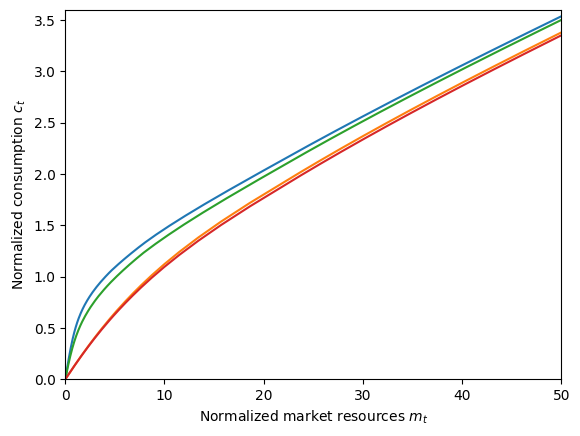

In [6]:
# Solve the serial unemployment consumer's problem and display solution
start_time = process_time()
SerialUnemploymentExample.solve()
end_time = process_time()
print(
    "Solving a Markov consumer with serially correlated unemployment took "
    + mystr(end_time - start_time)
    + " seconds.",
)
print("Consumption functions for each discrete state:")
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plt.ylim(0.0, 3.6)
plot_funcs(SerialUnemploymentExample.solution[0].cFunc, 0.0, 50)
if SerialUnemploymentExample.vFuncBool:
    print("Value functions for each discrete state:")
    plot_funcs(SerialUnemploymentExample.solution[0].vFunc, 0.5, 50)

In [7]:
# Simulate some data; results stored in cHist, mNrm_hist, cNrm_hist, and Mrkv_hist
if do_simulation:
    SerialUnemploymentExample.T_sim = 120
    SerialUnemploymentExample.MrkvPrbsInit = [0.25, 0.25, 0.25, 0.25]
    SerialUnemploymentExample.track_vars = ["mNrm", "cNrm"]
    SerialUnemploymentExample.make_shock_history()  # This is optional
    SerialUnemploymentExample.initialize_sim()
    SerialUnemploymentExample.simulate()

/opt/hostedtoolcache/Python/3.10.19/x64/lib/python3.10/site-packages/HARK/core.py:1415: UserWarning: The option for reading shocks was activated but the model requires state PlvlAgg, not contained in newborn_init_history.
  warn(
/opt/hostedtoolcache/Python/3.10.19/x64/lib/python3.10/site-packages/HARK/core.py:1783: UserWarning: The option for reading shocks was activated but the model requires state PlvlAgg, not contained in newborn_init_history.
  warn(


### 2. Unemployment immunity for a fixed period

Let's create a consumer similar to the one in "idiosyncratic shock" model but who occasionally gets "unemployment immunity" for a fixed period in an economy subject to boom and bust cycles.

In [8]:
# Make a consumer who occasionally gets "unemployment immunity" for a fixed period
UnempPrb = 0.05  # Probability of becoming unemployed each period
ImmunityPrb = 0.01  # Probability of becoming "immune" to unemployment
ImmunityT = 6  # Number of periods of immunity

In [9]:
StateCount = ImmunityT + 1  # Total number of Markov states
IncomeDstnReg = DiscreteDistributionLabeled(
    pmv=np.array([1 - UnempPrb, UnempPrb]),
    atoms=np.array([[1.0, 1.0], [1.0 / (1.0 - UnempPrb), 0.0]]),
    var_names=["PermShk", "TranShk"],
)  # Ordinary income distribution
IncomeDstnImm = DiscreteDistributionLabeled(
    pmv=np.array([1.0]),
    atoms=np.array([[1.0], [1.0]]),
    var_names=["PermShk", "TranShk"],
)
IncomeDstn = [IncomeDstnReg] + ImmunityT * [
    IncomeDstnImm,
]  # Income distribution for each Markov state, in a list

In [10]:
# Make the Markov transition array.  MrkvArray[i,j] is the probability of transitioning
# to state j in period t+1 from state i in period t.
MrkvArray = np.zeros((StateCount, StateCount))
MrkvArray[0, 0] = (
    1.0 - ImmunityPrb
)  # Probability of not becoming immune in ordinary state: stay in ordinary state
MrkvArray[0, ImmunityT] = (
    ImmunityPrb  # Probability of becoming immune in ordinary state: begin immunity periods
)
for j in range(ImmunityT):
    MrkvArray[j + 1, j] = (
        1.0  # When immune, have 100% chance of transition to state with one fewer immunity periods remaining
    )

In [11]:
init_unemployment_immunity = copy(init_indshk_markov)
init_unemployment_immunity["MrkvArray"] = [MrkvArray]
ImmunityExample = MarkovConsumerType(**init_unemployment_immunity)
ImmunityExample.assign_parameters(MrkvArray=[MrkvArray])
ImmunityExample.assign_parameters(
    Rfree=[
        np.array(np.array(StateCount * [1.03]))
    ],  # Interest factor same in all states
    PermGroFac=[
        np.array(StateCount * [1.01]),
    ],  # Permanent growth factor same in all states
    LivPrb=[np.array(StateCount * [0.98])],  # Same survival probability in all states
    BoroCnstArt=None,  # No artificial borrowing constraint
    cycles=0,
)  # Infinite horizon
ImmunityExample.IncShkDstn = [IncomeDstn]

Solving an "unemployment immunity" consumer took 0.3261 seconds.
Consumption functions for each discrete state:


/opt/hostedtoolcache/Python/3.10.19/x64/lib/python3.10/site-packages/HARK/interpolation.py:2194: RuntimeWarning: All-NaN slice encountered
  y = self.compare(fx, axis=1)


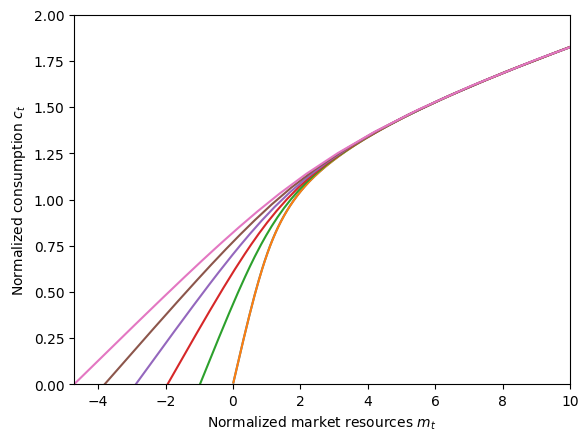

In [12]:
# Solve the unemployment immunity problem and display the consumption functions
start_time = process_time()
ImmunityExample.solve()
end_time = process_time()
print(
    'Solving an "unemployment immunity" consumer took '
    + mystr(end_time - start_time)
    + " seconds.",
)
print("Consumption functions for each discrete state:")
mNrmMin = np.min([ImmunityExample.solution[0].mNrmMin[j] for j in range(StateCount)])
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plt.ylim(0.0, 2.0)
plot_funcs(ImmunityExample.solution[0].cFunc, mNrmMin, 10)

### 3. Serial permanent income growth

Let's create a consumer similar to the one in "idiosyncratic shock" model but who faces serially correlated permanent income growth in an economy subject to boom and bust cycles.

In [13]:
# Make a consumer with serially correlated permanent income growth
UnempPrb = 0.05  # Unemployment probability
StateCount = 5  # Number of permanent income growth rates
Persistence = (
    0.5  # Probability of getting the same permanent income growth rate next period
)

In [14]:
IncomeDstnReg = DiscreteDistributionLabeled(
    pmv=np.array([1 - UnempPrb, UnempPrb]),
    atoms=np.array([[1.0, 1.0], [1.0, 0.0]]),
    var_names=["PermShk", "TranShk"],
)
IncomeDstn = StateCount * [
    IncomeDstnReg,
]  # Same simple income distribution in each state

In [15]:
# Make the state transition array for this type: Persistence probability of remaining in the same state, equiprobable otherwise
MrkvArray = Persistence * np.eye(StateCount) + (1.0 / StateCount) * (
    1.0 - Persistence
) * np.ones((StateCount, StateCount))

In [16]:
init_serial_growth = copy(init_indshk_markov)
init_serial_growth["MrkvArray"] = [MrkvArray]
SerialGroExample = MarkovConsumerType(**init_serial_growth)
SerialGroExample.assign_parameters(MrkvArray=[MrkvArray])
SerialGroExample.assign_parameters(
    Rfree=[
        np.array(
            np.array(StateCount * [1.03]),
        )
    ],  # Same interest factor in each Markov state
    PermGroFac=[
        np.array([0.97, 0.99, 1.01, 1.03, 1.05]),
    ],  # Different permanent growth factor in each Markov state
    LivPrb=[np.array(StateCount * [0.98])],  # Same survival probability in all states
    cycles=0,
)
SerialGroExample.IncShkDstn = [IncomeDstn]

Solving a serially correlated growth consumer took 0.2574 seconds.
Consumption functions for each discrete state:


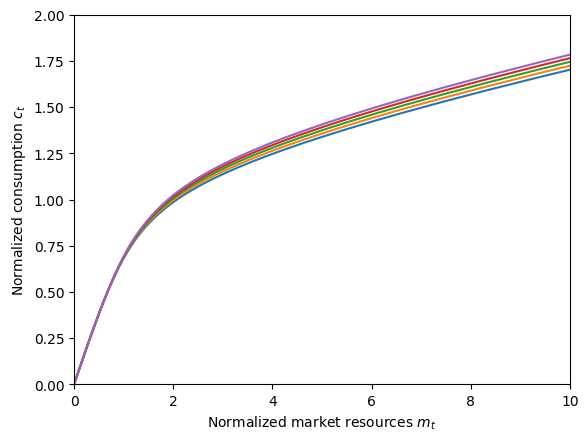

In [17]:
# Solve the serially correlated permanent growth shock problem and display the consumption functions
start_time = process_time()
SerialGroExample.solve()
end_time = process_time()
print(
    "Solving a serially correlated growth consumer took "
    + mystr(end_time - start_time)
    + " seconds.",
)
print("Consumption functions for each discrete state:")
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plt.ylim(0.0, 2.0)
plot_funcs(SerialGroExample.solution[0].cFunc, 0, 10)

### 4. Serial Interest factor

Finally, suppose that the consumer faces a interest factor serially correlated while his/her permanent income growth rate is constant.

In [18]:
# Make a consumer with serially correlated interest factors
SerialRExample = deepcopy(SerialGroExample)  # Same as the last problem...
SerialRExample.assign_parameters(
    PermGroFac=[
        np.array(StateCount * [1.01]),
    ],  # ...but now the permanent growth factor is constant...
    Rfree=[np.array([1.01, 1.02, 1.03, 1.04, 1.05])],
)  # ...and the interest factor is what varies across states

Solving a serially correlated interest consumer took 0.2322 seconds.
Consumption functions for each discrete state:


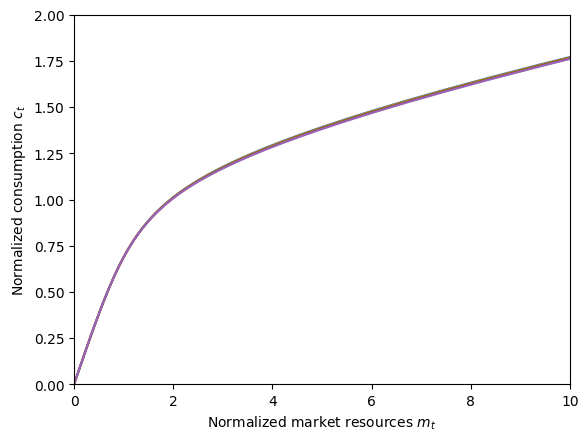

In [19]:
# Solve the serially correlated interest rate problem and display the consumption functions
start_time = process_time()
SerialRExample.solve()
end_time = process_time()
print(
    "Solving a serially correlated interest consumer took "
    + mystr(end_time - start_time)
    + " seconds.",
)
print("Consumption functions for each discrete state:")
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plt.ylim(0.0, 2.0)
plot_funcs(SerialRExample.solution[0].cFunc, 0, 10)